<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 15/11/2025</span>
    <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/sagaTrip/blob/main/nbs/08_AgentFromFirstPrinciple.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    </p>
</div>


In the age of LLM, there is a big explosion of autonomy populary known as Agentic systems. An agent, in the LLM context, is indeed about giving the model capabilities beyond just generating text. While an LLM can produce intelligent responses, an agent framework allows it to take actions, use tools, and interact with external systems.

Think of it this way:
- **LLM alone**: Can reason and generate text, but is isolated
- **LLM as an agent**: Can use tools, call APIs, execute code, access databases, and take actions based on its reasoning

Aim: There are many lib which tailors to various niche areas for this activity. Some are boated comes with steep learning curve. Here we are going to implement agentic system for **file search agent** an LLM from ground up. Our goal is to search your filesystem using tools like `find`, `grep`, and `ls`.
```text
We will learn how agents work by implementing one ourself, understanding:
- How to give LLMs access to tools
- How to handle tool calls safely
- How to create an agent loop that reasons and acts
```

We have to implement everything from scratch from first principle. For llm calling we will use `litellm` a thing wrapper and aggregator, `toolslm` for tool calling helper. The model to use `groq/openai/gpt-oss-20b`.

In this experiment I am using Groq for LLM inferenece, any other LLM system with tool calling can be used in its place. I have already setup the api from [Groq](https://console.groq.com/keys) and set it as env variable name `GROQ_API_KEY`. If you are useing colab add this in secret.

In [ ]:
#|hide
# install dependecies
!pip install -q litellm toolslm lisette fastcore graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
from lisette.core import mk_msg
import litellm
import os

model_name = "groq/openai/gpt-oss-20b"

In [ ]:
#|hide
try:
    from google.colab import userdata
    os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
    print("GROQ_API_KEY loaded from Colab secrets.")

except ImportError:
    print("Not running in Google Colab.")

GROQ_API_KEY loaded from Colab secrets.


Before we build our agent, let's understand the foundation: how messages work in LLM systems. Every interaction is structured as messages with specific roles.

## Building MSG

In [4]:
m = "Oh Hello There, Myself Sagar"
mk_msg(m)

{'role': 'user', 'content': 'Oh Hello There, Myself Sagar'}

Lets go deeper on the above output. Here there are couple of things to keep in mind.
1. **Role** : indicate various palyer in the a simple message. Below are fewer
    - **user** : message sent by the user, like the message one sent to the chatgpt text box
    - **system** : overall the behviour of the given system
    - **assistant** : model responses
    - **think** : special thinking for the reasoning model
    - **tool** : tool call
2. **content** : attributes for each field


In [5]:
mk_msg("You are a helpful math assistant", role='system'), mk_msg("What is 5 + 3?", role='user'),mk_msg("The answer is 8", role='assistant')

({'role': 'system', 'content': 'You are a helpful math assistant'},
 {'role': 'user', 'content': 'What is 5 + 3?'},
 {'role': 'assistant', 'content': 'The answer is 8'})

In [6]:
msg = [
    mk_msg("You are a helpful math assistant", role='system'),
    mk_msg("What is 5 + 3?", role='user'),
    #mk_msg("The answer is 8", role='assistant')
]
msg

[{'role': 'system', 'content': 'You are a helpful math assistant'},
 {'role': 'user', 'content': 'What is 5 + 3?'}]

## litellm setup

In [7]:
r = litellm.completion(
    model=model_name,
    messages=msg,
)
r.choices

[Choices(finish_reason='stop', index=0, message=Message(content='The answer is 8.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields=None, reasoning='The user asks: "What is 5 + 3?" It\'s a simple arithmetic question. The answer is 8. We should respond simply.'))]

In [8]:
print(r.choices[0].message.content)
print(r.choices[0].message.role)

The answer is 8.
assistant


Let's break down the key parts of the response. The `r.choices[0].message` contains:
- **content**: '5 + 3 = 8' - This is the actual text response from the model
- **role**: 'assistant' - This indicates the message came from the assistant (the LLM)

This is exactly the format we need if we wanted to continue the conversation! We have to append this message to msg list, then add another user message, and call the API again. This is known as **conversational context**, the pattern would be :
1. Start with your initial messages (system + user)
1. Get the response from the LLM
1. Append that assistant message to your msg list
1. Add a new user message
1. Call the API again with the full history
This way, the model "remembers" what was said before. As you noted, longer context = more tokens = more cost and processing time, but also more coherent conversations.

In [9]:
next_msg = msg + [
    mk_msg(r.choices[0].message.content, role=r.choices[0].message.role),
    mk_msg("can you explain the resoning behind it as I am a 5 year old", role="user")
]
next_msg

[{'role': 'system', 'content': 'You are a helpful math assistant'},
 {'role': 'user', 'content': 'What is 5 + 3?'},
 {'role': 'assistant', 'content': 'The answer is 8.'},
 {'role': 'user',
  'content': 'can you explain the resoning behind it as I am a 5 year old'}]

In [10]:
r = litellm.completion(
    model=model_name,
    messages=next_msg,
)
r

Sure! Let’s think about it like a fun game with apples.

1. **Start with 5 apples.**  
   Imagine you have a bowl that already holds 5 shiny apples. Count them:  
   1, 2, 3, 4, 5.  
   So, we have **5 apples**.

2. **Add 3 more apples.**  
   Now someone puts 3 extra apples into the same bowl.  
   Count the new apples:  
   1, 2, 3.  
   So, we’re adding **3 apples** to the bowl.

3. **Count all the apples together.**  
   Put the 5 apples and the 3 new apples in one big group and count everything:  
   1, 2, 3, 4, 5, **6, 7, 8**.  
   That gives us **8 apples** in total.

So, when we do “5 + 3,” we’re just putting the 5 things and the 3 things together and seeing how many we have altogether. And that number is 8. Easy peasy!

<details>

- id: `chatcmpl-3c23ed54-473f-4729-bb1d-eabf3829de6f`
- model: `openai/gpt-oss-20b`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=376, prompt_tokens=120, total_tokens=496, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=126, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None, queue_time=0.020862679, prompt_time=0.005752552, completion_time=0.370259862, total_time=0.376012414)`

</details>

Now that we understand how LLMs handle conversations, let's put this to work. We'll build an agent that can actually do things - specifically, search files using command-line tools. This demonstrates how agents combine reasoning (LLM) with actions (tool execution).



## Building a Safe File Search Agent

An **agent** in the LLM context is a system that can take actions beyond just generating text. While a standard LLM can reason and respond, an agent can execute commands, use tools, and interact with external systems.

In this section, we're building a **file search agent** that can help users find and search through files using common bash commands like `find`, `grep`, and `ls`. This is a practical example because:

1. **Real-world utility**: File searching is a common task that benefits from natural language interfaces
2. **Safety-first design**: We'll implement strict safeguards to ensure read-only operations
3. **Multi-tool coordination**: The LLM must decide which tools to use and in what order


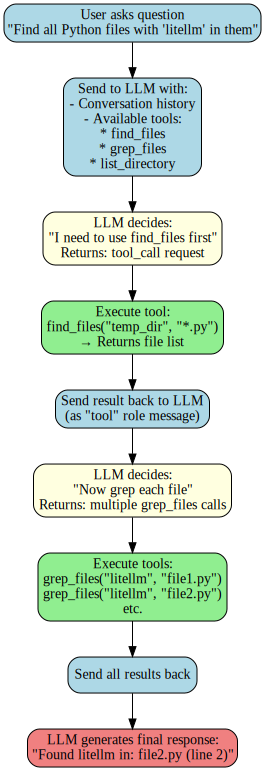

In [ ]:
#|echo: false

from graphviz import Digraph

def agent_flow_chart():
    dot = Digraph(comment='Agent File Search Flow')
    dot.attr(rankdir='TB')
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

    # Add nodes
    dot.node('1', 'User asks question\n"Find all Python files with \'litellm\' in them"')
    dot.node('2', 'Send to LLM with:\n- Conversation history\n- Available tools:\n  * find_files\n  * grep_files\n  * list_directory')
    dot.node('3', 'LLM decides:\n"I need to use find_files first"\nReturns: tool_call request', fillcolor='lightyellow')
    dot.node('4', 'Execute tool:\nfind_files("temp_dir", "*.py")\n→ Returns file list', fillcolor='lightgreen')
    dot.node('5', 'Send result back to LLM\n(as "tool" role message)')
    dot.node('6', 'LLM decides:\n"Now grep each file"\nReturns: multiple grep_files calls', fillcolor='lightyellow')
    dot.node('7', 'Execute tools:\ngrep_files("litellm", "file1.py")\ngrep_files("litellm", "file2.py")\netc.', fillcolor='lightgreen')
    dot.node('8', 'Send all results back')
    dot.node('9', 'LLM generates final response:\n"Found litellm in: file2.py (line 2)"', fillcolor='lightcoral')

    # Add edges
    dot.edge('1', '2')
    dot.edge('2', '3')
    dot.edge('3', '4')
    dot.edge('4', '5')
    dot.edge('5', '6')
    dot.edge('6', '7')
    dot.edge('7', '8')
    dot.edge('8', '9')

    return dot

agent_flow_chart()

In [12]:
from toolslm.funccall import get_schema
import json
from fastcore.xtras import run

### Mock Setup for File Search

Created `temp_dir` and some dummy files to perform agent.

In [13]:
import os

def test_setup():
    # Clean up and create directories
    os.system('rm -rf temp_dir')
    os.makedirs('temp_dir/subdir', exist_ok=True)

    # Create file1.py
    with open('temp_dir/file1.py', 'w') as f:
        f.write('''import numpy as np
from fastcore.xtras import run

def safe_run(cmd):
    return run(cmd)

def helper():
    pass
''')

    # Create file2.py
    with open('temp_dir/file2.py', 'w') as f:
        f.write('''import pandas as pd
import litellm

def process_data():
    return "data"
''')

    # Create file3.py
    with open('temp_dir/subdir/file3.py', 'w') as f:
        f.write('''from fastcore.script import call_parse

def deep_function():
    pass
''')

    # Create test.ipynb
    with open('temp_dir/test.ipynb', 'w') as f:
        f.write('''{
 "cells": [
  {
   "cell_type": "code",
   "source": ["import litellm\\nprint('hello')"]
  }
 ]
}
''')

    # Create another.ipynb
    with open('temp_dir/subdir/another.ipynb', 'w') as f:
        f.write('''{
 "cells": [
  {
   "cell_type": "code",
   "source": ["def safe_run():\\n    pass"]
  }
 ]
}
''')

    # Verify
    os.system('find temp_dir -type f')

test_setup()

### Safe Run Safety Considerations
The flowchart shows our target architecture. But before implementing the tools, we must address a critical concern: security. Since our agent executes shell commands, we need strict safeguards. Our agent will perform only read operation no delete, update or execute.
- **Whitelist commands only**: Only `find`, `grep`, and `ls` are allowed
- **Block dangerous characters**: No pipes (`|`), semicolons (`;`), or command substitution
- **Read-only operations**: No `rm`, `mv`, `cp`, or file modification commands
- **Structured arguments**: Using command lists instead of shell strings to prevent injection


In [14]:
ALLOWED_COMMANDS = {'find', 'grep', 'ls'}
DANGEROUS_CHARS = {'|', ';', '&', '>', '<', '`', '$', '(', ')'}

def safe_run(cmd_list):
    """Safely execute only whitelisted commands"""
    if not cmd_list:
        raise ValueError("Empty command list")

    if cmd_list[0] not in ALLOWED_COMMANDS:
        raise ValueError(f"Command '{cmd_list[0]}' not allowed. Only {ALLOWED_COMMANDS} permitted.")

    # Check for shell operators
    for item in cmd_list:
        if any(char in str(item) for char in DANGEROUS_CHARS):
            raise ValueError(f"Dangerous characters detected in command")

    return run(cmd_list)

In [15]:
# Option 1: Using try/except
dangerous_tests = [
    ['rm', 'file'],           # Not in whitelist
    ['find', '.', ';', 'rm'], # Semicolon
    ['grep', 'test', '&'],    # Ampersand
    ['ls', '-lart', '|', 'wc']
]

for c in dangerous_tests:
    try:
        safe_run(c)
        print("FAILED - should have raised error")
    except ValueError as e:
        print(f"PASSED - caught error: {e}")

PASSED - caught error: Command 'rm' not allowed. Only {'find', 'ls', 'grep'} permitted.
PASSED - caught error: Dangerous characters detected in command
PASSED - caught error: Dangerous characters detected in command
PASSED - caught error: Dangerous characters detected in command


In [16]:
assert safe_run(['find', '.', '-name', '*.ipynb']) != '', "find should return output"
assert type(safe_run(['ls', '-la'])) == str


With safety established, let's build the actual tools our agent will use. Each tool wraps a command-line utility with a clean Python interface.

### Find

In [17]:
def find_files(
    directory: str,      # Starting directory (e.g., ".", "/home/user")
    name: str = "*",     # Filename pattern (e.g., "*.py", "test*")
    file_type: str = '', # File type: "f" (file), "d" (dir), or None (any)
    maxdepth: int = -1   # Limit search depth for safety
) -> str:
    """Find files matching criteria"""
    cmd = ["find", directory]

    if maxdepth != -1:
        cmd += ['-maxdepth', str(maxdepth)]

    if file_type != '':
        cmd += ['-type', file_type]

    cmd += ["-name", name]

    try:
        return safe_run(cmd)
    except (IOError, OSError) as e:
        return f"Error: {str(e)}"

In [18]:
print(find_files('temp_dir', '*.py', maxdepth=5))

temp_dir/file2.py
temp_dir/file1.py
temp_dir/subdir/file3.py


### Grep files

**For `grep_files` (grep):**
- `pattern: str` - What to search for
- `file_path: str` - Which file to search in
- `ignore_case: bool = False` - Case-insensitive? (translates to `-i`)
- `line_numbers: bool = False` - Show line numbers? (translates to `-n`)
- `show_filename: bool = True` - filenames to always appear for context (`-H` - Always show filename/`-h` - Never show filename)


In [19]:
def grep_files(
    pattern: str,                 #  Pattern to search for
    file_path: str,               # Single file to search in
    ignore_case: bool = False,    # Case-insensitive search (-i)
    line_numbers: bool = False,   # Show line numbers (-n)
    show_filename: bool = True    # Always show filename (-H)
) -> str:
    """Search for pattern in a single file using grep

    For searching multiple files, first use find_files to get the list,
    then call grep_files on each file separately.

    Args:
        pattern: Text pattern to search for
        file_path: Path to a single file to search (not wildcards)
        ignore_case: If True, ignore case when matching
        line_numbers: If True, show line numbers in output
        show_filename: If True, always show filename in output

    Returns:
        Grep output showing matching lines
    """
    cmd = ["grep"]

    if ignore_case:
        cmd.append('-i')

    if line_numbers:
        cmd.append('-n')

    if show_filename:
        cmd.append('-H')
    else:
        cmd.append('-h')

    cmd += [pattern, file_path]

    try:
        return safe_run(cmd)
    except (IOError, OSError):
        # grep returns exit code 1 when no matches found
        return ""

In [20]:
print(grep_files('import ', 'temp_dir/file2.py', line_numbers=True))

temp_dir/file2.py:1:import pandas as pd
temp_dir/file2.py:2:import litellm


In [21]:
print(grep_files('import ', 'temp_dir/*', line_numbers=True))

### List Directory
**For `list_directory` (ls):**
- `directory: str` - Which directory to list
- `show_hidden: bool = False` - Include hidden files? (translates to `-a`)
- `long_format: bool = False` - Detailed listing? (translates to `-l`)


In [22]:

def list_directory(
    directory: str,
    show_hidden: bool = False,
    long_format: bool = False,
) -> str :
    """List directory given a directory"""
    cmd = ["ls"]
    if show_hidden: cmd.append('-a')
    if long_format: cmd.append('-l')
    cmd.append(directory)

    try:
        return safe_run(cmd)
    except (IOError, OSError) as e:
        return f"Error: {str(e)}"

In [23]:
print(list_directory('temp_dir'))

file1.py
file2.py
subdir
test.ipynb


We have our safe tools ready. Now comes the key part: teaching the LLM about these tools so it can decide when and how to use them. This is where tool schemas come in.

### Basic Tool Object


**Tools are functions** - Like `find_files`, `grep_files` and `list_directory` functions that perform actual actions.

**The model needs to know about them** - We must describe these tools to the LLM using a schema (name, description, parameters) so it knows:
- What tools are available
- What each tool does
- What inputs each tool expects

**This prevents confusion** - Without clear descriptions, the LLM wouldn't know it can call these tools or how to use them properly.

We will use, `toolslm` uses to generate the schema automatically! The structure required for `Groq/OpenAI expects`.

**Note**: If you are using any thing other than the model `groq/openai/gpt-oss-20b` you have to tweek the tool format required for that model.

```json
[
  {
    "type": "function",
    "function": {
      "name": "list_directory",
      "description": "List directory given a directory\n\nReturns:\n- type: string",
      "parameters": {
        "type": "object",
        "properties": {
          "directory": {
            "type": "string",
            "description": ""
          },
          "show_hidden": {
            "type": "boolean",
            "description": "",
            "default": false
          },
          "long_format": {
            "type": "boolean",
            "description": "",
            "default": false
          }
        },
        "required": ["directory"]
      }
    }
  }
]

```

In [24]:
def build_tool(func):
    return {
        "type": "function",
        "function": get_schema(func, pname='parameters')
         }
tools = [build_tool(i) for i in (list_directory, grep_files, find_files)]
tools

[{'type': 'function',
  'function': {'name': 'list_directory',
   'description': 'List directory given a directory\n\nReturns:\n- type: string',
   'parameters': {'type': 'object',
    'properties': {'directory': {'type': 'string', 'description': ''},
     'show_hidden': {'type': 'boolean', 'description': '', 'default': False},
     'long_format': {'type': 'boolean', 'description': '', 'default': False}},
    'required': ['directory']}}},
 {'type': 'function',
  'function': {'name': 'grep_files',
   'description': 'Search for pattern in a single file using grep\n\n    For searching multiple files, first use find_files to get the list,\n    then call grep_files on each file separately.\n\n    Args:\n        pattern: Text pattern to search for\n        file_path: Path to a single file to search (not wildcards)\n        ignore_case: If True, ignore case when matching\n        line_numbers: If True, show line numbers in output\n        show_filename: If True, always show filename in output

Since we are using a reasoning model that can do arithmetic on its own, need to **force** it to use the calculator tools.

Here's what the `tool_choice` parameter does:
- **`None`** (default): Model won't use tools at all
- **`"auto"`**: Model decides whether to use tools (might skip them for simple math)
- **`"required"`**: Model MUST use one of the provided tools

Note : After using required, the model we are using is a Reasoning Model. There is a chance it can do the simple arithmetic without waiting for tool use stuff.

### Tool Loop

In [ ]:
# llm call
def invoke(pr):
    return litellm.completion(
        model=model_name,
        messages=pr,
        tools=tools,
        tool_choice="auto"
    )

In [ ]:
# basic message setup
def get_msg(msg):
    return [
        mk_msg(role="system", content="You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs."),
        mk_msg(role="user", content=msg,)
    ]

pr = get_msg('list all the files in the current directory.')
pr

[{'role': 'system',
  'content': 'You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs.'},
 {'role': 'user', 'content': 'list all the files in the current directory.'}]

In [27]:
pr = get_msg('list all the files in the current directory.')
res = invoke(pr)
res



🔧 list_directory({"directory":"."})


<details>

- id: `chatcmpl-a6f7fc62-0ea0-4316-b348-9d4dfa6ee025`
- model: `openai/gpt-oss-20b`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=35, prompt_tokens=532, total_tokens=567, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=12, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None, queue_time=0.01802854, prompt_time=0.02795786, completion_time=0.034892549, total_time=0.062850409)`

</details>

In [ ]:
# to check if the resp have the tool_calls
def has_tools(res):
    return hasattr(res.choices[0].message, 'tool_calls')

In [29]:
has_tools(res)

True

Extract the function from the tool object of the response.

In [30]:
def res2func_nm(res):
    if hasattr(res.choices[0].message.tool_calls[0], 'function'):
        func_name  = res.choices[0].message.tool_calls[0].function.name
        func = globals().get(func_name, None)
        return func

    return False

res2func_nm(res)

<function __main__.list_directory(directory: str, show_hidden: bool = False, long_format: bool = False) -> str>

Extract the function kwargs from the tool object of the response.

In [31]:
def get_res2func_kwargs(res):
    if hasattr(res.choices[0].message.tool_calls[0], 'function'):
        func_kwargs = res.choices[0].message.tool_calls[0].function.arguments
        func_kwargs = json.loads(func_kwargs)
        return func_kwargs

    return False

get_res2func_kwargs(res)

{'directory': '.'}

Now we need to add two things to your message history:

1. **The assistant's message** (with the tool_calls) - so the LLM knows what it asked for
2. **The tool result** - as a message with `role='tool'`

The assistant's message:
- `"role"` : `'assistant'`
- `"content"` : `""`
- `"tool_calls"` : `res.choices[0].message.tool_calls`

The tool result message needs:
- `role`: `'tool'`
- `tool_call_id`: The ID from the tool call
- `content`: The result as a string


In [ ]:


def build_next_call(res):
    """A helper function to extract new messages with tools and assitant prompt."""
    func = res2func_nm(res)
    func_kwargs = get_res2func_kwargs(res)

    t_msg = mk_msg({
        "role":'tool',
        'tool_call_id':res.choices[0].message.tool_calls[0].id,
        'content':str(func(**func_kwargs))
    })
    a_msg= mk_msg({
        "role":'assistant',
        "content": "",
        'tool_calls': res.choices[0].message.tool_calls
    })
    return [ a_msg, t_msg]

In [ ]:
def next_msg(pr, res):
    """extracting and appending the new prompts from `res` i.e for tool and assiant to the original prompt `pr` """
    return pr + build_next_call(res)

pr_ = next_msg(pr, res)
pr_

[{'role': 'system',
  'content': 'You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs.'},
 {'role': 'user', 'content': 'list all the files in the current directory.'},
 {'role': 'assistant',
  'content': '',
  'tool_calls': [ChatCompletionMessageToolCall(function=Function(arguments='{"directory":"."}', name='list_directory'), id='fc_a63bcd76-0a4c-4a1a-a880-894fbcd464db', type='function')]},
 {'role': 'tool',
  'tool_call_id': 'fc_a63bcd76-0a4c-4a1a-a880-894fbcd464db',
  'content': 'sample_data\ntemp_dir'}]

In [34]:
pr = get_msg('list all the files in the current directory.')
res = invoke(pr)
res



🔧 list_directory({"directory":"."})


<details>

- id: `chatcmpl-950fe2b9-7e08-424d-ba34-183d566f7aa0`
- model: `openai/gpt-oss-20b`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=31, prompt_tokens=532, total_tokens=563, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=8, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None, queue_time=0.017648798, prompt_time=0.030200318, completion_time=0.030406804, total_time=0.060607122)`

</details>

In [35]:
if has_tools(res):
    func_nm, func_kwargs = res2func_nm(res), get_res2func_kwargs(res)
func_nm, func_kwargs

(<function __main__.list_directory(directory: str, show_hidden: bool = False, long_format: bool = False) -> str>,
 {'directory': '.'})

In [36]:
res_ = invoke(pr_)
res_

The current directory contains:

- `sample_data`
- `temp_dir`

<details>

- id: `chatcmpl-2925729f-ea58-4708-8977-406fd029e125`
- model: `openai/gpt-oss-20b`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=53, prompt_tokens=561, total_tokens=614, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=29, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None, queue_time=0.020229679, prompt_time=0.029933307, completion_time=0.051773638, total_time=0.081706945)`

</details>

The model returns `finish_reason` as `stop` for stopping the exexcution.

In [37]:
res_.choices[0].finish_reason

'stop'

The LLM now knows our tools exist. The final piece is the agent loop: repeatedly calling the LLM, executing its requested tools, and feeding back results until the task completes.

In [38]:
from pprint import pprint

def tool_loop(pr, max_steps=10, debug=False):
    """Execute agentic loop: LLM calls tools until task is complete"""

    # Display initial messages
    print("\n### Initial Messages:")
    for msg in pr:
        role = msg['role']
        content = msg.get('content', '[tool_call]')
        print(f"**{role}**: {content}")

    for step in range(max_steps):
        print(f"\n{'='*20} Step {step} {'='*20}")

        res = invoke(pr)

        # Debug: show full response
        if debug:
            print("\n**Debug - Full Response:**")
            pprint(res.choices[0].message.model_dump())

        # Check if done
        if not has_tools(res) or res.choices[0].finish_reason == 'stop':
            print("\n✓ Complete! Final response:\n")
            content = res.choices[0].message.content
            if content:
                print(content)
            return res

        # Extract and execute tool
        func = res2func_nm(res)
        func_kwargs = get_res2func_kwargs(res)

        print(f"🔧 Tool: {func.__name__}")
        print(f"   Args: {func_kwargs}")

        pr = next_msg(pr, res)

        result_preview = pr[-1]['content'][:200]
        print(f"   Result: {result_preview}{'...' if len(pr[-1]['content']) > 200 else ''}")

    print(f"\n⚠️ Max steps ({max_steps}) reached!")
    return res

In [39]:
pr = get_msg('list all the files in the "temp_dir" directory.')
_ = tool_loop(pr, debug=True)


### Initial Messages:
**system**: You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs.
**user**: list all the files in the "temp_dir" directory.

==================== Step 0 ====================

**Debug - Full Response:**
{'content': None,
 'function_call': None,
 'reasoning': "User wants to list all files in temp_dir directory. We'll call "
              'list_directory.',
 'role': 'assistant',
 'tool_calls': [{'function': {'arguments': '{"directory":"temp_dir","long_format":false,"show_hidden":false}',
                              'name': 'list_directory'},
                 'id': 'fc_f10ea2ae-a331-492e-a9df-b245850dffa4',
                 'type': 'function'}]}
🔧 Tool: list_directory
   Args: {'directory': 'temp_dir', 'long_format': False, 'show_hidden': False}
   Result: file1.py
file2.py
subdir
test.ipyn

In [40]:
pr = get_msg("Search for all .ipynb files in temp_dir, but only go 2 levels deep")
_ = tool_loop(pr, max_steps=10)


### Initial Messages:
**system**: You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs.
**user**: Search for all .ipynb files in temp_dir, but only go 2 levels deep

==================== Step 0 ====================
🔧 Tool: find_files
   Args: {'directory': 'temp_dir', 'file_type': 'f', 'maxdepth': 2, 'name': '*.ipynb'}
   Result: temp_dir/subdir/another.ipynb
temp_dir/test.ipynb

==================== Step 1 ====================

✓ Complete! Final response:

Here are the `.ipynb` files found in `temp_dir` (search depth limited to 2 levels):

- `temp_dir/test.ipynb`  
- `temp_dir/subdir/another.ipynb`


In [41]:
# Simple tests
test_prompts = [
    # Find files
    "Find all Python files in temp_dir",
    "Search for all .ipynb files in temp_dir, but only go 2 levels deep",
    "Find all directories in temp_dir",

    # Grep tests
    "Search for the word 'import' in the file temp_dir/file1.py",
    "Find all lines containing 'litellm' in temp_dir/test.ipynb",

    # Multi-tool tests
    "Find all Python files in temp_dir and then search for 'def safe_run' in them",
    "Look for all .py files in temp_dir and tell me which ones contain the word 'fastcore'",
]


In [42]:
test_prompts[::3]

['Find all Python files in temp_dir',
 "Search for the word 'import' in the file temp_dir/file1.py",
 "Look for all .py files in temp_dir and tell me which ones contain the word 'fastcore'"]

I am just calling the tool for 3 prompts. As I am using free tier for service. It might fail with the rate limiting error, please wait and retry.
The llm might give wrong ans like not searching a directory(due to the non deterministic nature of the model inference). There is an awsome blog from [Thinking Machine Lab](https://thinkingmachines.ai/blog/defeating-nondeterminism-in-llm-inference/) for this specific behaviour.

In [51]:
for i in test_prompts[::3]:
    pr = get_msg(i)
    _ = tool_loop(pr, max_steps=10)
    pprint("***" * 35 )


### Initial Messages:
**system**: You help users find and search files safely using command-line tools. Use find_files for locating files, grep_files for searching content, and list_directory for browsing. Provide clear, accurate results based only on tool outputs.
**user**: Find all Python files in temp_dir

==================== Step 0 ====================
🔧 Tool: find_files
   Args: {'directory': 'temp_dir', 'file_type': 'f', 'name': '*.py'}
   Result: temp_dir/file2.py
temp_dir/file1.py
temp_dir/subdir/file3.py

==================== Step 1 ====================

✓ Complete! Final response:

Here are all the Python files located under `temp_dir`:

```
temp_dir/file2.py
temp_dir/file1.py
temp_dir/subdir/file3.py
```

Let me know if you’d like to inspect any of these files or search inside them!
'*********************************************************************************************************'

### Initial Messages:
**system**: You help users find and search files safely using 

## Conclusion

We've built a complete file search agent from scratch, demystifying how LLM agents actually work under the hood. Starting with simple message structures, we progressed through safe tool design, schema generation, and finally implemented a full agent loop that reasons and acts.

**Key takeaways:**

- **Agents = LLM reasoning + tool execution** - The model decides *what* to do, your code provides the *how*
- **Safety first** - Whitelisting commands and validating inputs is crucial when executing system commands
- **The agent loop is simple** - It's just: call LLM → execute tools → feed back results → repeat until done
- **Tool schemas bridge the gap** - They teach the LLM what capabilities it has available

This foundation extends far beyond file search. The same patterns work for:
- Database agents that query and analyze data
- Web automation agents using Playwright or Selenium  
- API integration agents that coordinate multiple services
- Code execution agents for data science workflows and many more

By building from first principle, we understand exactly what's happening at each step, making debugging easier and giving us full control over safety, costs, and behavior.
